# Set Up

In [0]:
!unzip data.zip

# Data processing

In [0]:
import glob
from keras.preprocessing.image import ImageDataGenerator, img_to_array
import cv2
import numpy as np

In [0]:
img_data_path = 'data/*/*'
img_paths = glob.glob(img_data_path)

In [0]:
img_paths[:5]

['data/letter_yes/90_134.png',
 'data/letter_yes/400_77.png',
 'data/letter_yes/415_129.png',
 'data/letter_yes/450_55.png',
 'data/letter_yes/14_131.png']

In [0]:
data = []
labels = []
for img_path in img_paths:
  img = cv2.imread(img_path)
  img = cv2.resize(img, (32, 32))
  data.append(img_to_array(img))
  if img_path.split('/')[-2] == 'letter_yes':
    labels.append(1)
  else:
    labels.append(0)

data = np.array(data, dtype="float64") / 255.0 
labels = np.asarray(labels)

data.shape, labels.shape

((21384, 32, 32, 3), (21384,))

In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [0]:
labels = to_categorical(labels, num_classes=2)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17107, 32, 32, 3), (17107, 2), (4277, 32, 32, 3), (4277, 2))

In [0]:
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Model

In [0]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, Input, Dropout
from keras.optimizers import Adam
import keras

In [0]:
def build_model():
  """Function to build model."""
  
  input_ = Input(shape=x_train.shape[1:], name="input_layer_1")
  
  x = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu", name="conv2d_layer_1")(input_)
  x = MaxPooling2D(pool_size=(2, 2) , strides=(2, 2), name="maxpool_layer_1")(x)
  x = Activation("relu", name="activation_layer_1")(x)
  
  x = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu", name="conv2d_layer_2")(x)
  x = MaxPooling2D(pool_size=(2, 2) , strides=(1, 1), name="maxpool_layer_2")(x)
  x = Activation("relu", name="activation_layer_2")(x)
  
  x = Conv2D(filters=8, kernel_size=(2, 2), strides=(1, 1), padding="same", activation="relu", name="conv2d_layer_3")(x)
  x = MaxPooling2D(pool_size=(2, 2) , strides=(1, 1), name="maxpool_layer_3")(x)
  x = Activation("relu", name="activation_layer_3")(x)
  
  x = Flatten(name="flat_1")(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.2, name="dropout_1")(x)
  
  output = Dense(2, name="prediction_layer", activation="softmax")(x)
  
  model = Model(
      inputs=[input_],
      outputs=[output]
  )
  return model

In [57]:
net = build_model()
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_1 (InputLayer)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_layer_1 (Conv2D)      (None, 16, 16, 64)        1792      
_________________________________________________________________
maxpool_layer_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
activation_layer_1 (Activati (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_layer_2 (Conv2D)      (None, 4, 4, 32)          18464     
_________________________________________________________________
maxpool_layer_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
activation_layer_2 (Activati (None, 3, 3, 32)          0         
__________

# Training

In [0]:
init_lr = 1e-3
epochs = 100
opt = Adam(lr=init_lr, decay=(init_lr/epochs))

In [0]:
net.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
batch_size=32

In [48]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.2, shuffle=True)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((13685, 32, 32, 3), (3422, 32, 32, 3), (13685, 2), (3422, 2))

In [54]:
from tensorflow.python.client import device_lib
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [59]:
H = net.fit_generator(
    aug.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train)//batch_size,
    epochs=epochs,
    verbose=2
)

Epoch 1/100
 - 10s - loss: 0.3140 - acc: 0.8599 - val_loss: 0.1811 - val_acc: 0.9348
Epoch 2/100
 - 10s - loss: 0.2340 - acc: 0.9072 - val_loss: 0.1682 - val_acc: 0.9340
Epoch 3/100
 - 10s - loss: 0.2260 - acc: 0.9094 - val_loss: 0.1823 - val_acc: 0.9307
Epoch 4/100
 - 10s - loss: 0.2106 - acc: 0.9137 - val_loss: 0.1587 - val_acc: 0.9372
Epoch 5/100
 - 10s - loss: 0.2041 - acc: 0.9165 - val_loss: 0.1514 - val_acc: 0.9395
Epoch 6/100
 - 10s - loss: 0.2003 - acc: 0.9155 - val_loss: 0.1580 - val_acc: 0.9354
Epoch 7/100
 - 10s - loss: 0.2038 - acc: 0.9130 - val_loss: 0.1678 - val_acc: 0.9337
Epoch 8/100
 - 10s - loss: 0.2070 - acc: 0.9125 - val_loss: 0.1513 - val_acc: 0.9369
Epoch 9/100
 - 10s - loss: 0.2001 - acc: 0.9168 - val_loss: 0.1488 - val_acc: 0.9407
Epoch 10/100
 - 10s - loss: 0.1985 - acc: 0.9165 - val_loss: 0.1445 - val_acc: 0.9404
Epoch 11/100
 - 10s - loss: 0.1963 - acc: 0.9166 - val_loss: 0.1866 - val_acc: 0.9258
Epoch 12/100
 - 10s - loss: 0.1949 - acc: 0.9192 - val_loss: 0.

In [0]:
import matplotlib.pyplot as plt

def plot_net_history(H):
  """Function to plot the loss."""
  plt.style.use('ggplot')
  plt.figure(figsize=(9, 6))
  N = 100
  
  for i in zip(["loss", "val_loss", "acc", "val_acc"], ["train_loss", "val_loss", "train_acc", "val_acc"]):
    plt.plot(np.arange(0, N), H.history[i[0]], label=i[1])
  plt.title("Training Loss and Accuracy on Character - No character")
  plt.xlabel("Epochs")
  plt.ylabel("loss / Accuracy")
  plt.legend(loc="lower left")
  plt.show() 

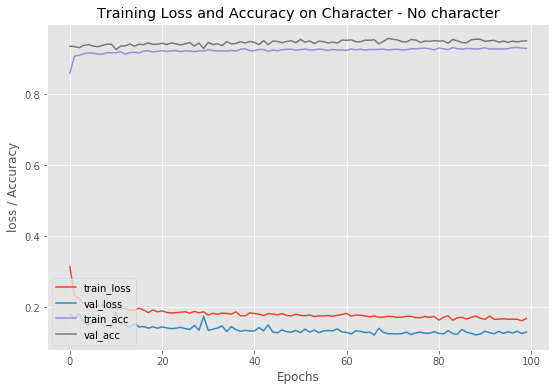

In [62]:
plot_net_history(H)

In [63]:
net.evaluate(x_test, y_test, verbose=2)

[0.13368882329275264, 0.9469254150105214]

In [64]:
y_pred = net.predict(x_test)
y_pred.shape

(4277, 2)

In [65]:
y_test.shape

(4277, 2)

In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

In [0]:
y_true = [np.argmax(i) for i in y_test]
y_pred = [np.argmax(i) for i in y_pred]

In [75]:
cm = confusion_matrix(y_pred, y_true)
cm

array([[1976,   94],
       [ 133, 2074]])

In [0]:
def plot_cm(cm, num_classes):
  """Function to plot the confusion matrix."""
  df_cm = pd.DataFrame(cm, range(num_classes), range(num_classes))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, annot_kws={'size': 16})

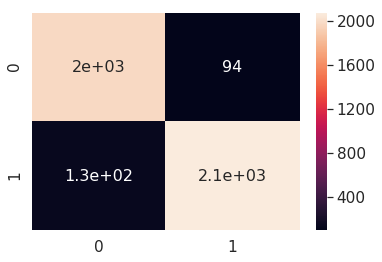

In [96]:
plot_cm(cm, 2)

In [98]:
y_true[:5], y_pred[:5]

([0, 0, 1, 0, 0], [0, 0, 1, 0, 0])

In [0]:
def view_img(y_true, y_pred):
  """Function to view the image."""
  fig = plt.figure()
  count = 0
  for i, v in enumerate(y_true):
    if y_true[i] == y_pred[i]:
      pass
    else:
      count += 1
      print('orig {} classified as {}'.format(y_true[i], y_pred[i]))
      plt.imshow(x_test[i], interpolation="nearest")
      plt.show()
  print("Images mis-classified {}".format(count))
# img = mpimg.imread()
# imgplot = plt.imshow(img)
# plt.show()

orig 0 classified as 1


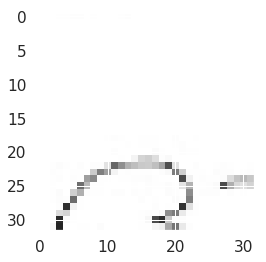

orig 1 classified as 0


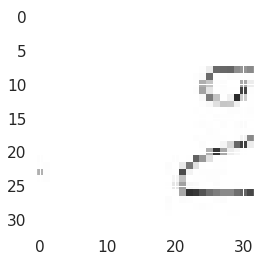

orig 0 classified as 1


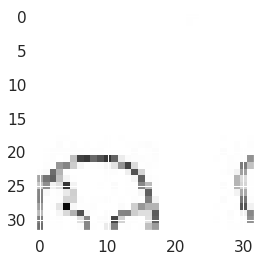

orig 1 classified as 0


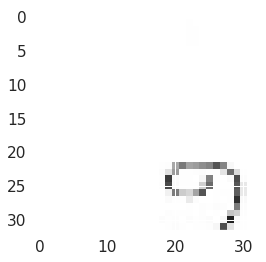

orig 1 classified as 0


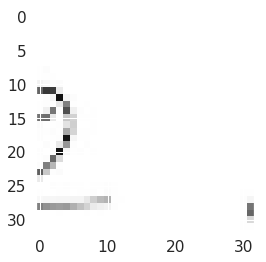

orig 0 classified as 1


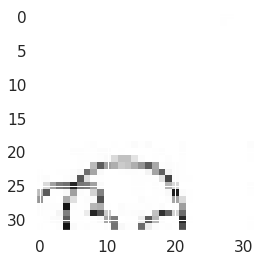

orig 1 classified as 0


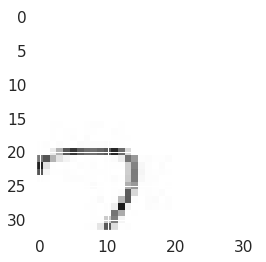

orig 1 classified as 0


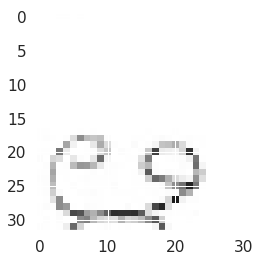

orig 0 classified as 1


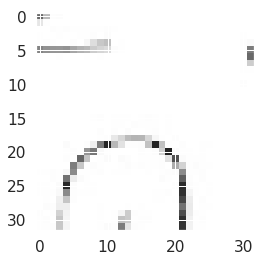

orig 1 classified as 0


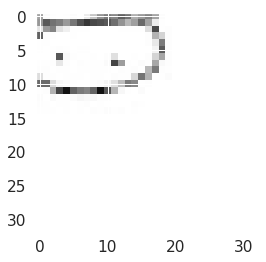

orig 1 classified as 0


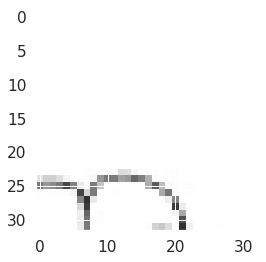

orig 1 classified as 0


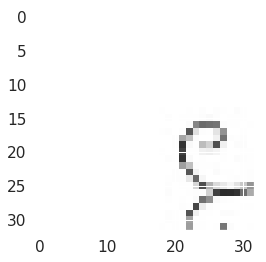

orig 1 classified as 0


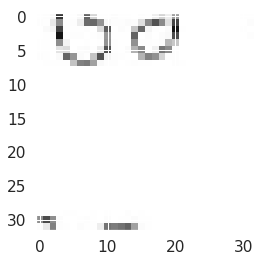

orig 0 classified as 1


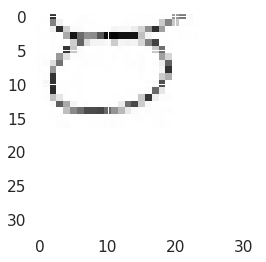

orig 1 classified as 0


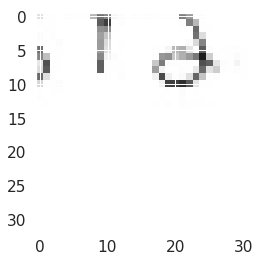

orig 1 classified as 0


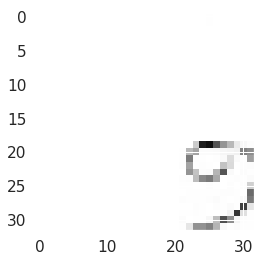

orig 0 classified as 1


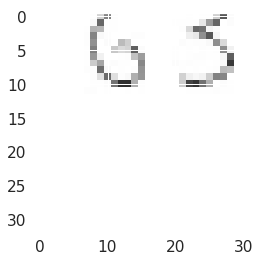

orig 0 classified as 1


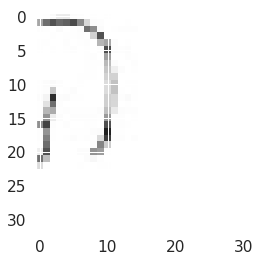

orig 0 classified as 1


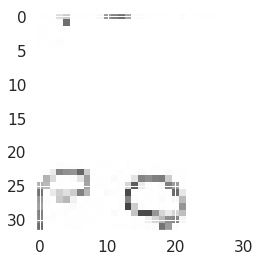

orig 0 classified as 1


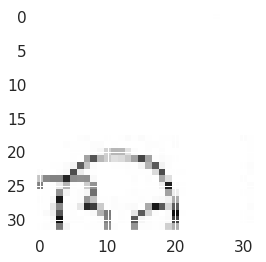

orig 0 classified as 1


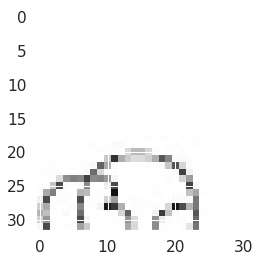

orig 1 classified as 0


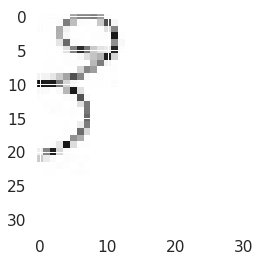

orig 0 classified as 1


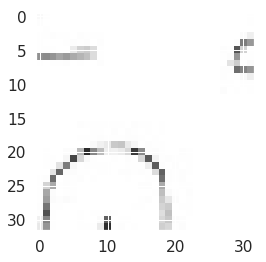

orig 1 classified as 0


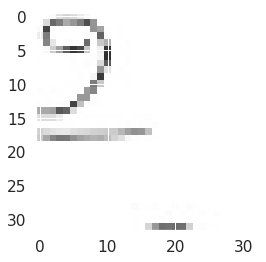

orig 1 classified as 0


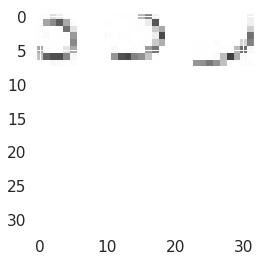

orig 0 classified as 1


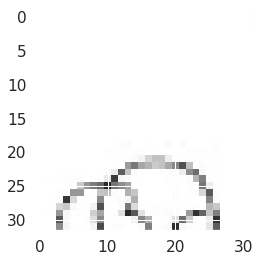

orig 0 classified as 1


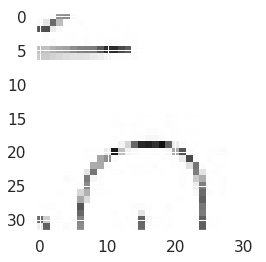

orig 0 classified as 1


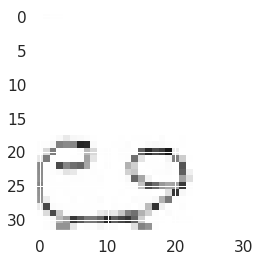

orig 1 classified as 0


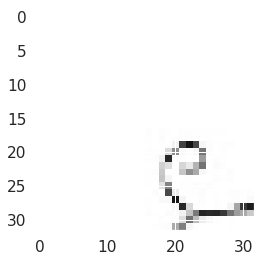

orig 1 classified as 0


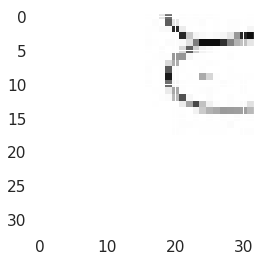

orig 0 classified as 1


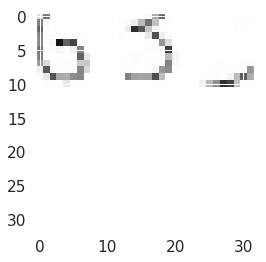

orig 1 classified as 0


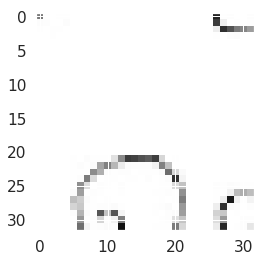

orig 1 classified as 0


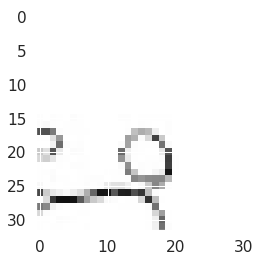

orig 1 classified as 0


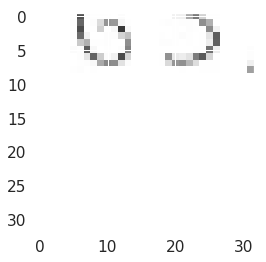

orig 0 classified as 1


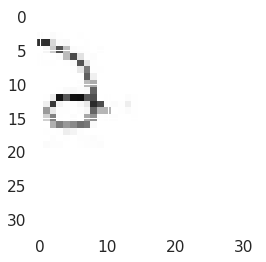

orig 0 classified as 1


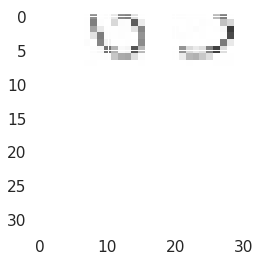

orig 0 classified as 1


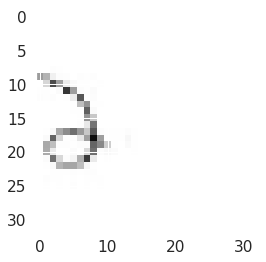

orig 1 classified as 0


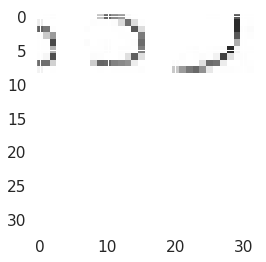

orig 1 classified as 0


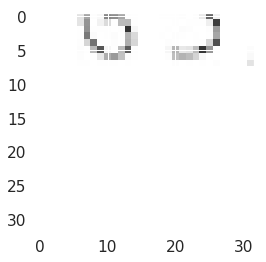

orig 0 classified as 1


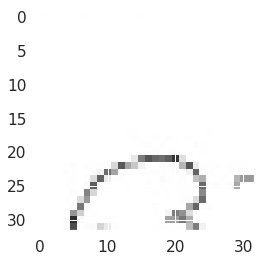

orig 1 classified as 0


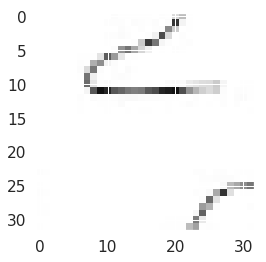

orig 1 classified as 0


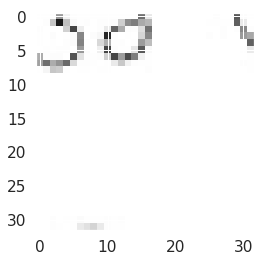

orig 0 classified as 1


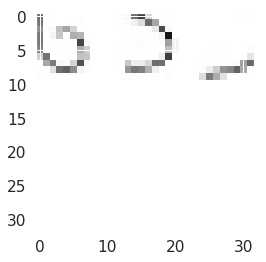

orig 0 classified as 1


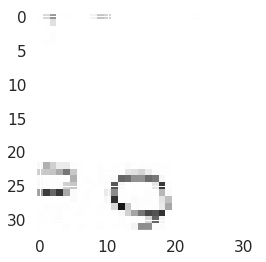

orig 1 classified as 0


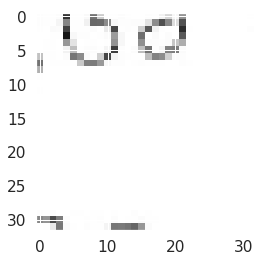

orig 0 classified as 1


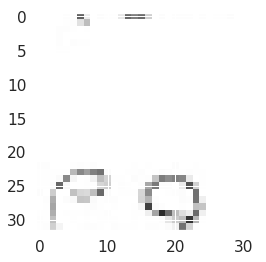

orig 0 classified as 1


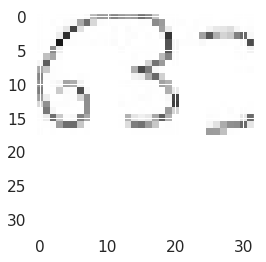

orig 0 classified as 1


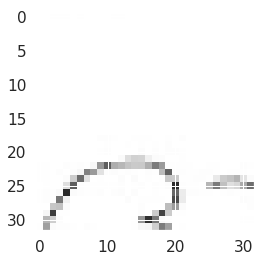

orig 1 classified as 0


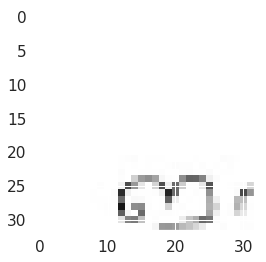

orig 1 classified as 0


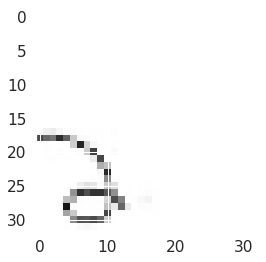

orig 0 classified as 1


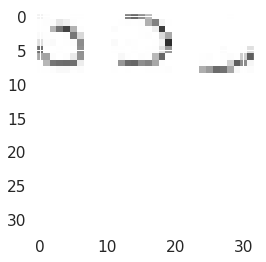

orig 0 classified as 1


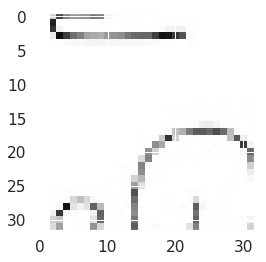

orig 1 classified as 0


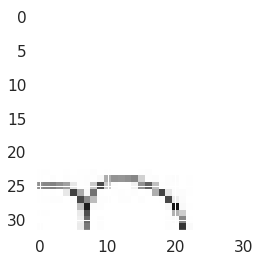

orig 1 classified as 0


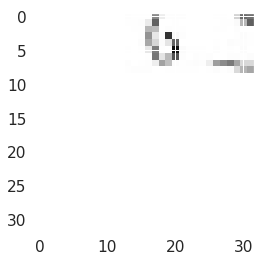

orig 0 classified as 1


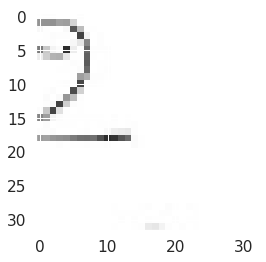

orig 0 classified as 1


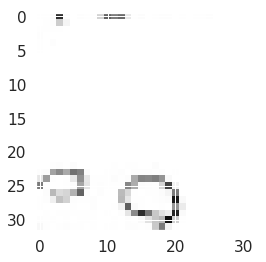

orig 0 classified as 1


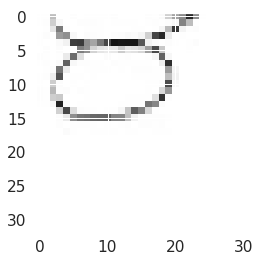

orig 1 classified as 0


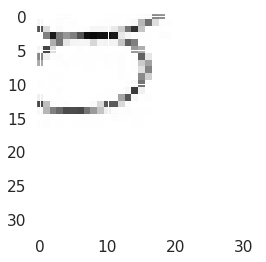

orig 0 classified as 1


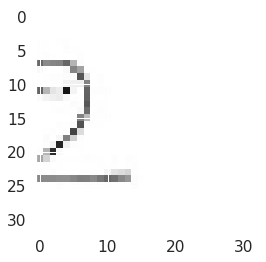

orig 1 classified as 0


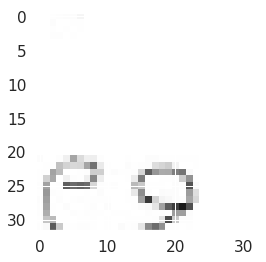

orig 0 classified as 1


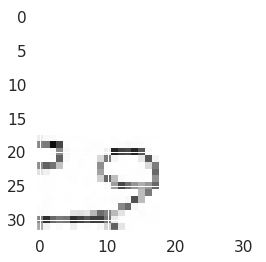

orig 0 classified as 1


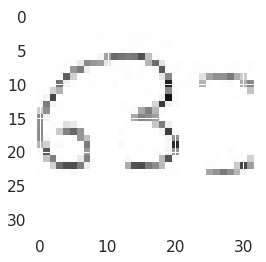

orig 0 classified as 1


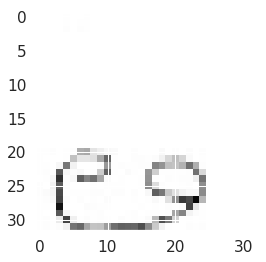

orig 0 classified as 1


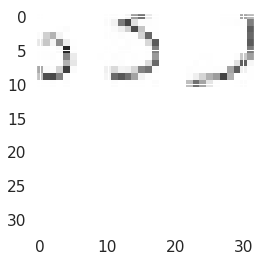

orig 1 classified as 0


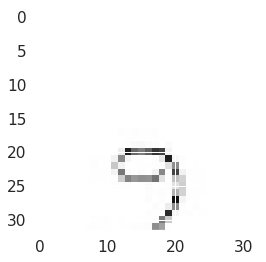

orig 1 classified as 0


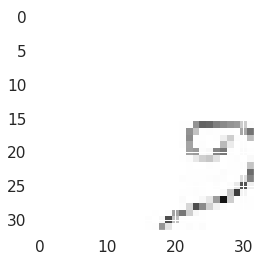

orig 1 classified as 0


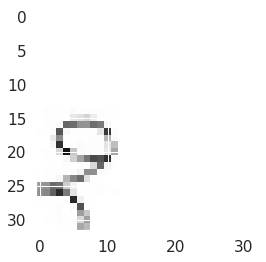

orig 1 classified as 0


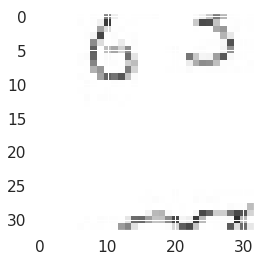

orig 1 classified as 0


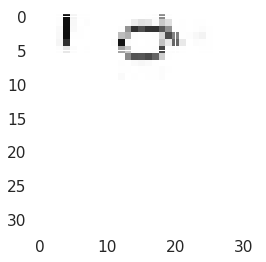

orig 1 classified as 0


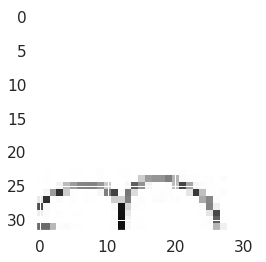

orig 0 classified as 1


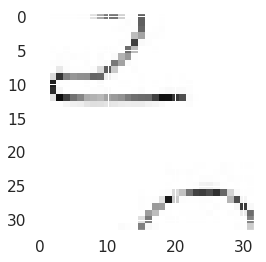

orig 0 classified as 1


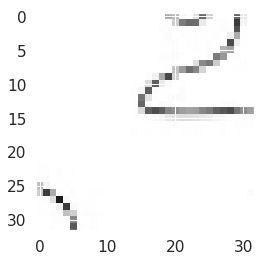

orig 0 classified as 1


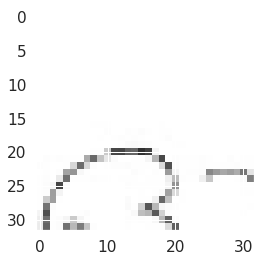

orig 0 classified as 1


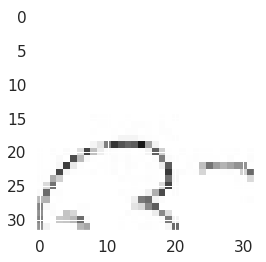

orig 1 classified as 0


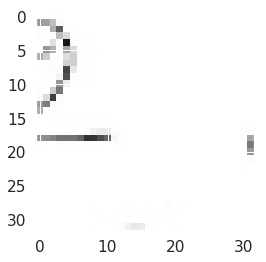

orig 1 classified as 0


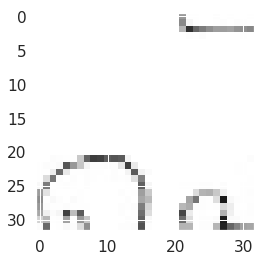

orig 0 classified as 1


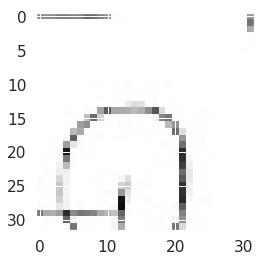

orig 0 classified as 1


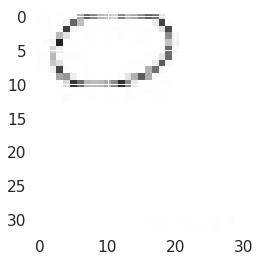

orig 1 classified as 0


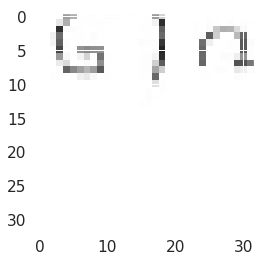

orig 0 classified as 1


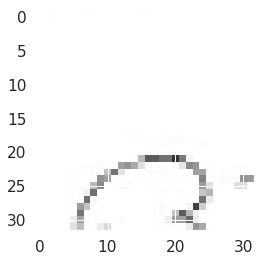

orig 0 classified as 1


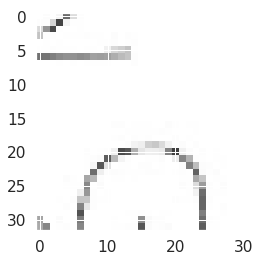

orig 0 classified as 1


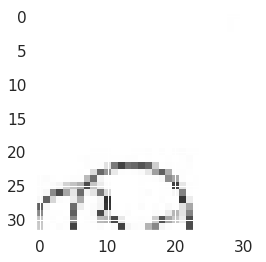

orig 0 classified as 1


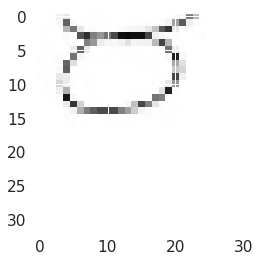

orig 0 classified as 1


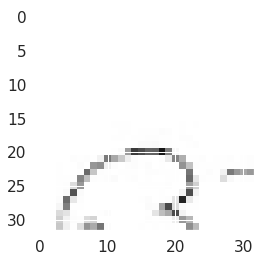

orig 0 classified as 1


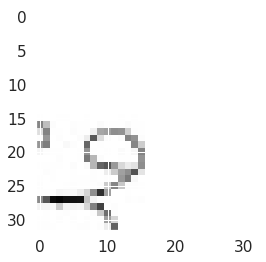

orig 0 classified as 1


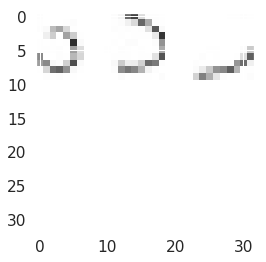

orig 0 classified as 1


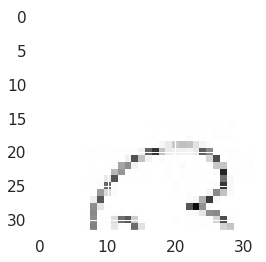

orig 0 classified as 1


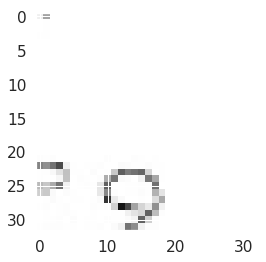

orig 0 classified as 1


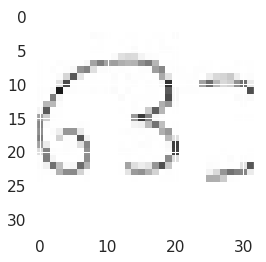

orig 1 classified as 0


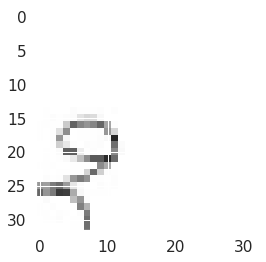

orig 1 classified as 0


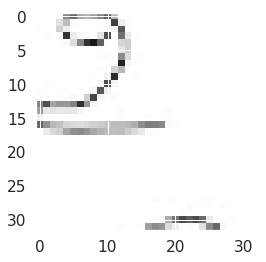

orig 0 classified as 1


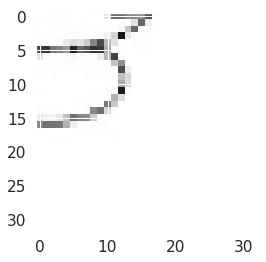

orig 0 classified as 1


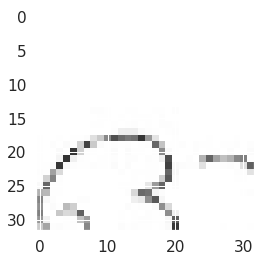

orig 1 classified as 0


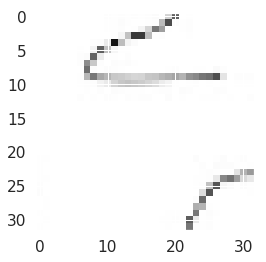

orig 1 classified as 0


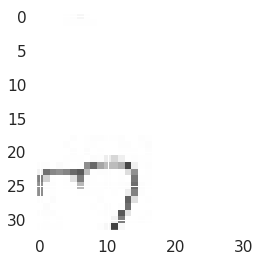

orig 0 classified as 1


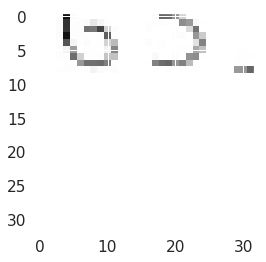

orig 0 classified as 1


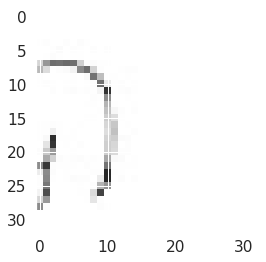

orig 0 classified as 1


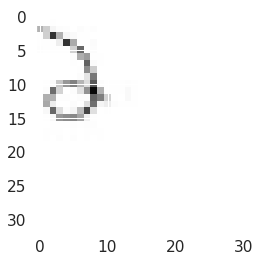

orig 0 classified as 1


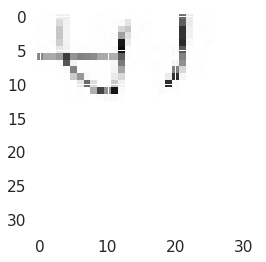

orig 0 classified as 1


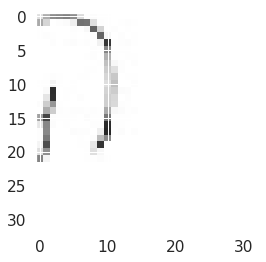

orig 0 classified as 1


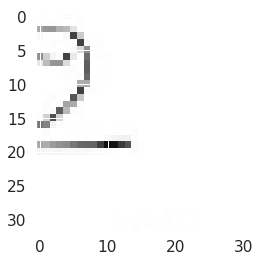

orig 1 classified as 0


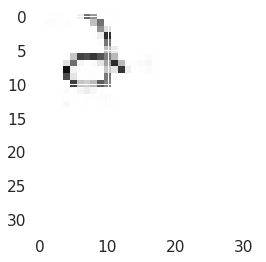

orig 0 classified as 1


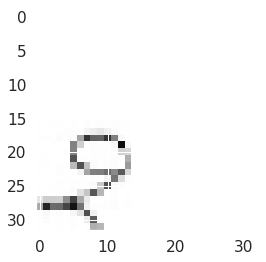

orig 0 classified as 1


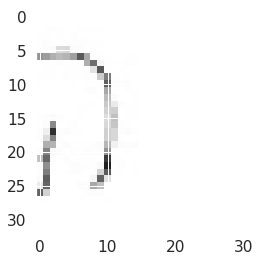

orig 1 classified as 0


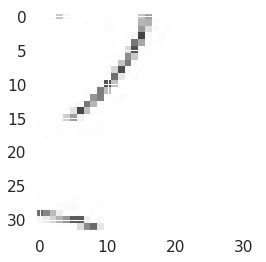

orig 0 classified as 1


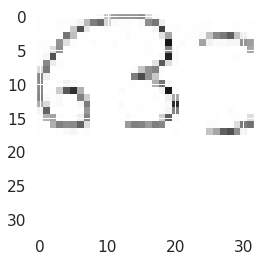

orig 1 classified as 0


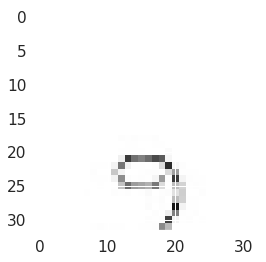

orig 1 classified as 0


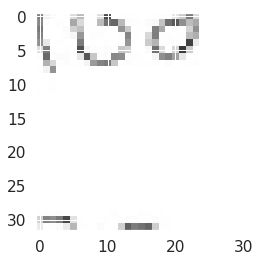

orig 0 classified as 1


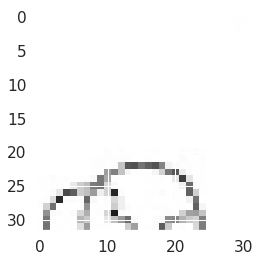

orig 0 classified as 1


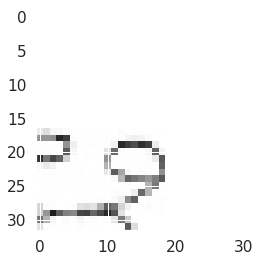

orig 1 classified as 0


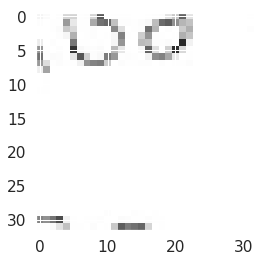

orig 0 classified as 1


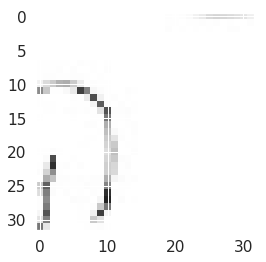

orig 0 classified as 1


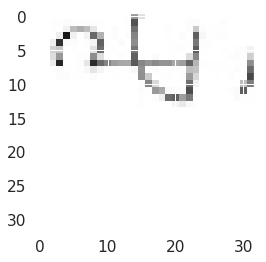

orig 0 classified as 1


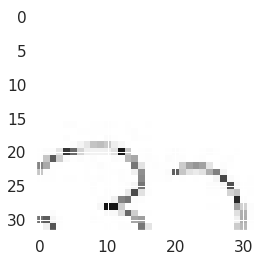

orig 1 classified as 0


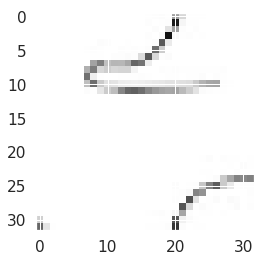

orig 0 classified as 1


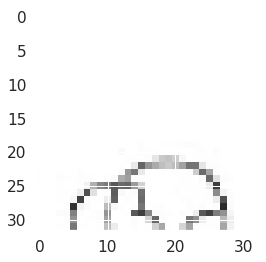

orig 0 classified as 1


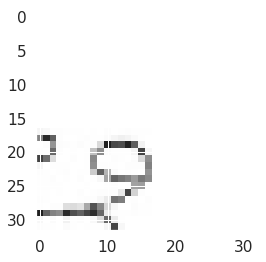

orig 0 classified as 1


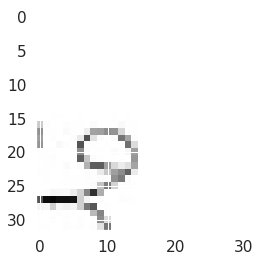

orig 0 classified as 1


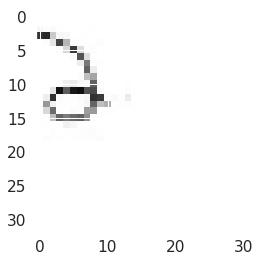

orig 0 classified as 1


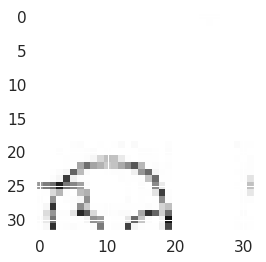

orig 0 classified as 1


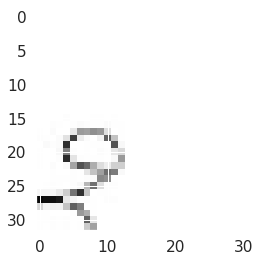

orig 0 classified as 1


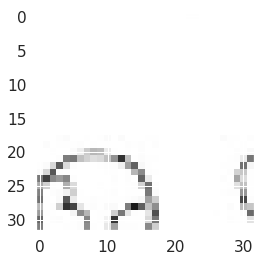

orig 0 classified as 1


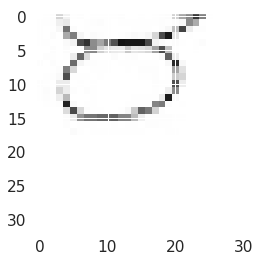

orig 1 classified as 0


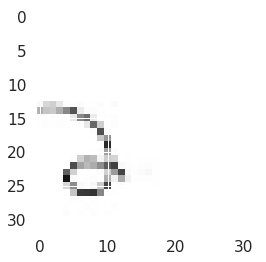

orig 1 classified as 0


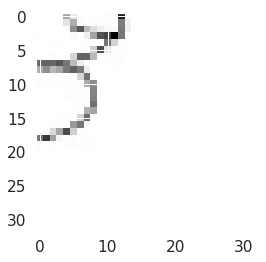

orig 0 classified as 1


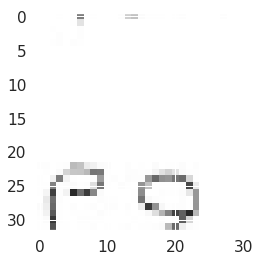

orig 0 classified as 1


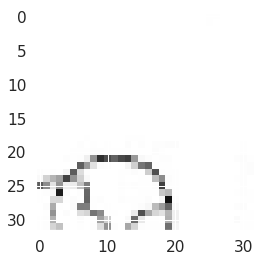

orig 0 classified as 1


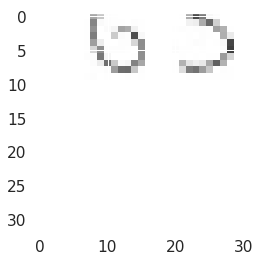

orig 0 classified as 1


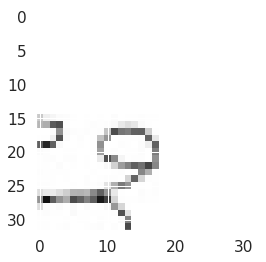

orig 1 classified as 0


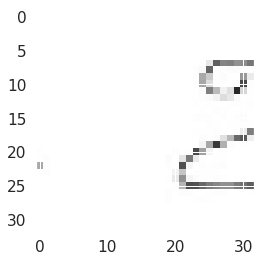

orig 0 classified as 1


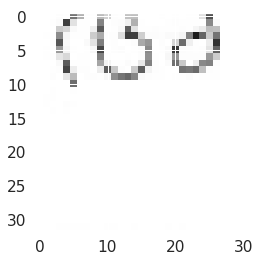

orig 0 classified as 1


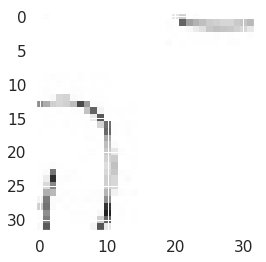

orig 0 classified as 1


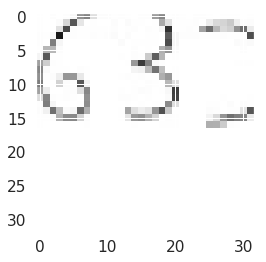

orig 0 classified as 1


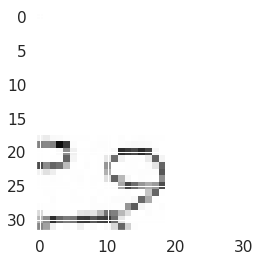

orig 0 classified as 1


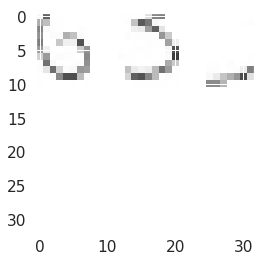

orig 1 classified as 0


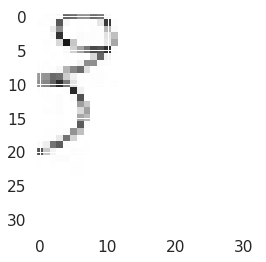

orig 1 classified as 0


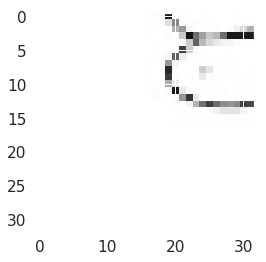

orig 1 classified as 0


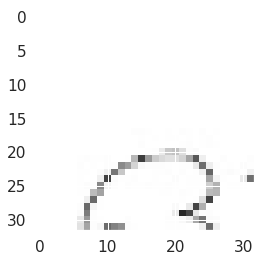

orig 1 classified as 0


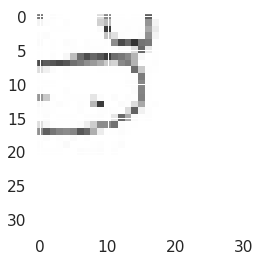

orig 0 classified as 1


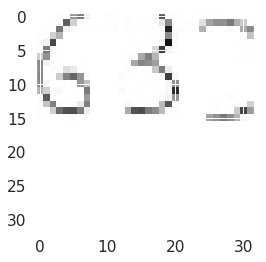

orig 0 classified as 1


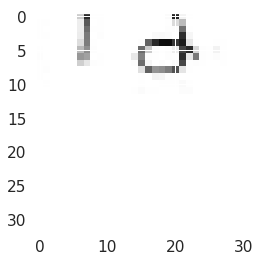

orig 0 classified as 1


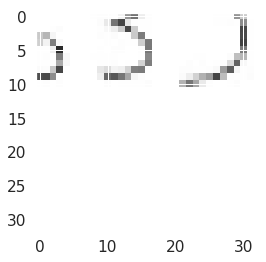

orig 1 classified as 0


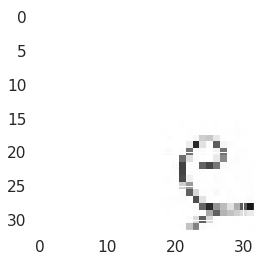

orig 1 classified as 0


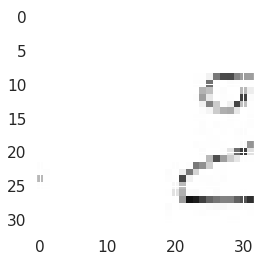

orig 0 classified as 1


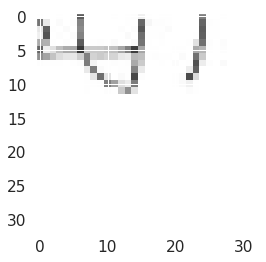

orig 1 classified as 0


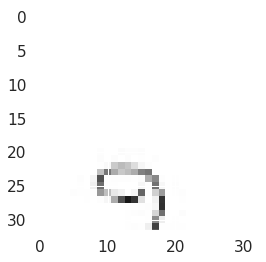

orig 0 classified as 1


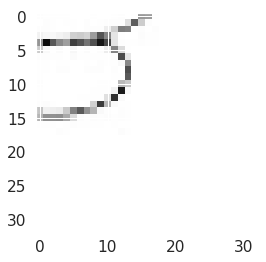

orig 1 classified as 0


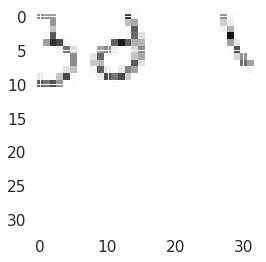

orig 1 classified as 0


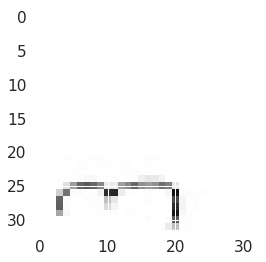

orig 0 classified as 1


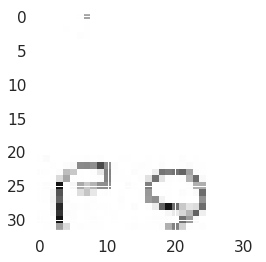

orig 1 classified as 0


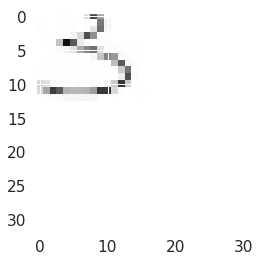

orig 1 classified as 0


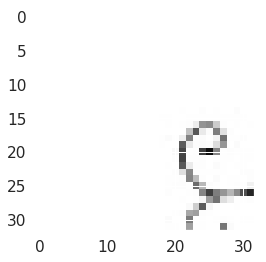

orig 0 classified as 1


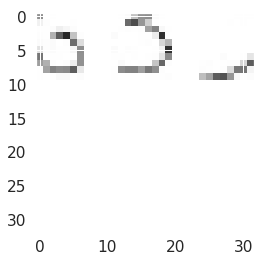

orig 0 classified as 1


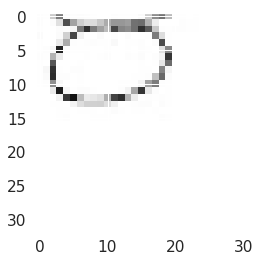

orig 1 classified as 0


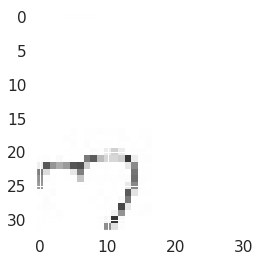

orig 0 classified as 1


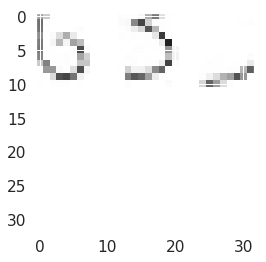

orig 1 classified as 0


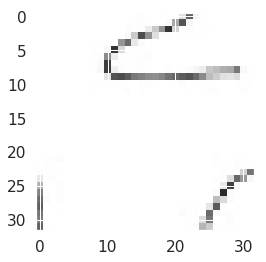

orig 1 classified as 0


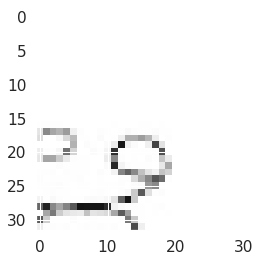

orig 1 classified as 0


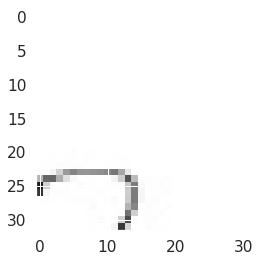

orig 1 classified as 0


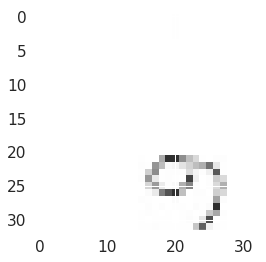

orig 1 classified as 0


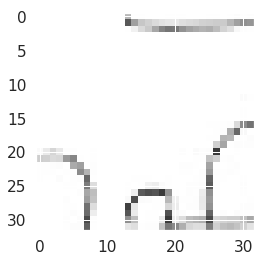

orig 0 classified as 1


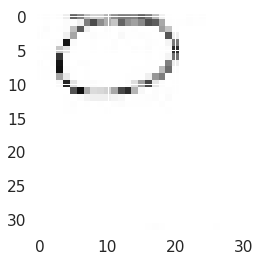

orig 0 classified as 1


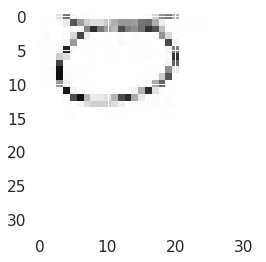

orig 0 classified as 1


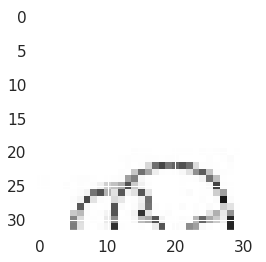

orig 0 classified as 1


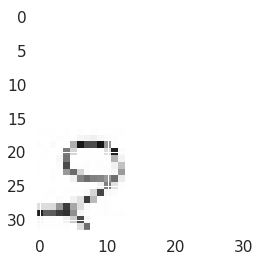

orig 0 classified as 1


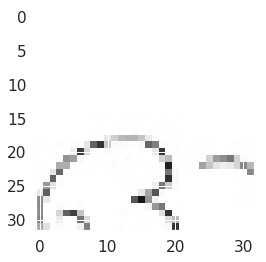

orig 1 classified as 0


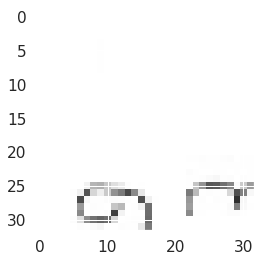

orig 0 classified as 1


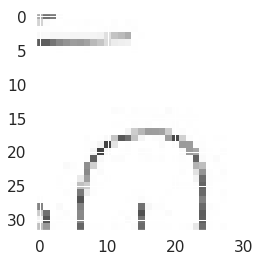

orig 0 classified as 1


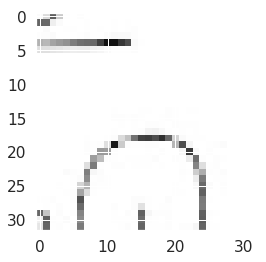

orig 1 classified as 0


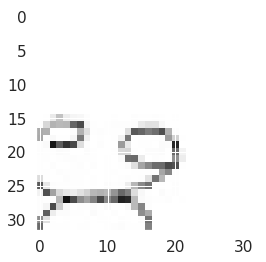

orig 0 classified as 1


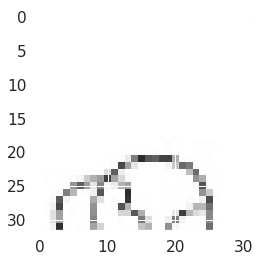

orig 0 classified as 1


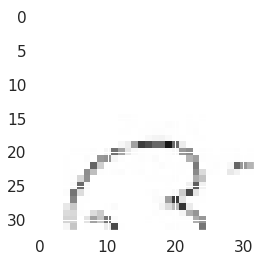

orig 1 classified as 0


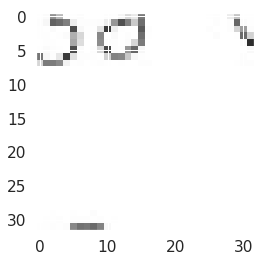

orig 0 classified as 1


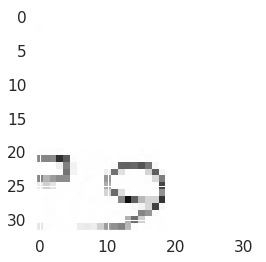

orig 1 classified as 0


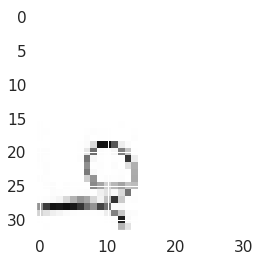

orig 1 classified as 0


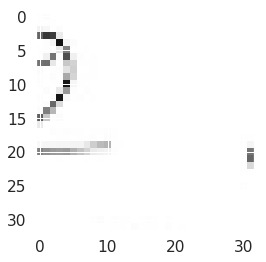

orig 0 classified as 1


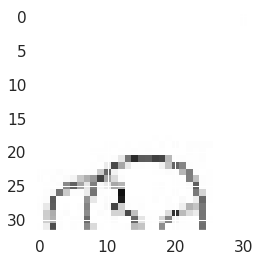

orig 0 classified as 1


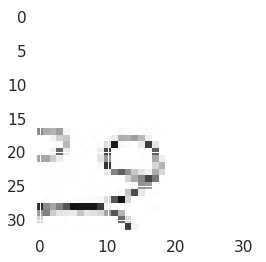

orig 1 classified as 0


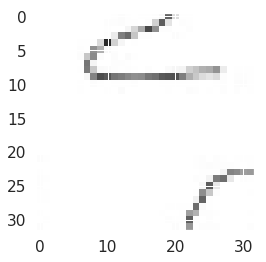

orig 0 classified as 1


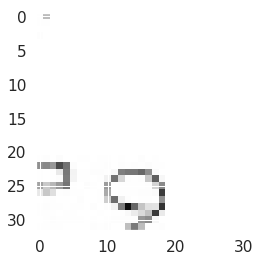

orig 1 classified as 0


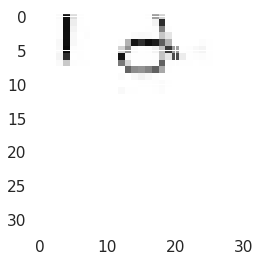

orig 1 classified as 0


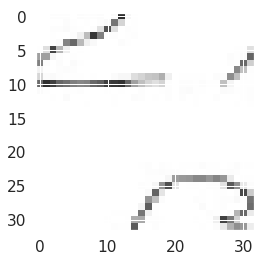

orig 1 classified as 0


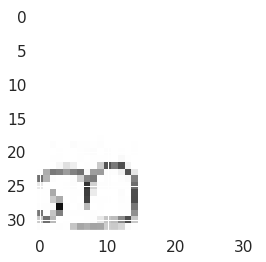

orig 0 classified as 1


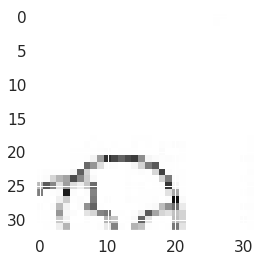

orig 1 classified as 0


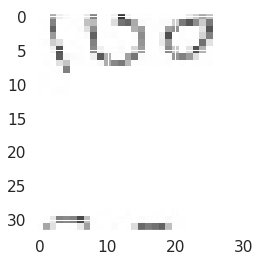

orig 1 classified as 0


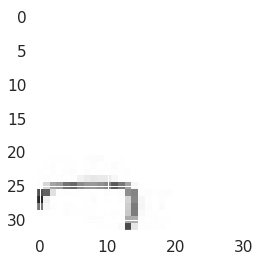

orig 0 classified as 1


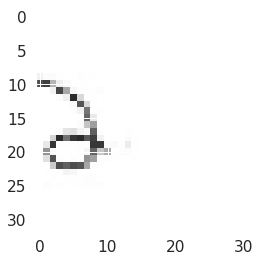

orig 0 classified as 1


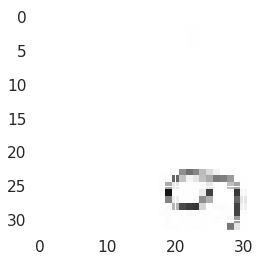

orig 0 classified as 1


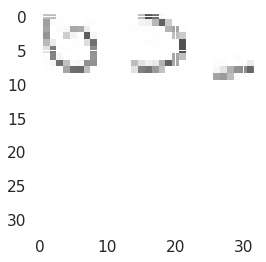

orig 1 classified as 0


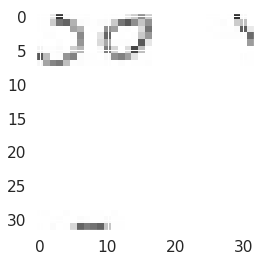

orig 1 classified as 0


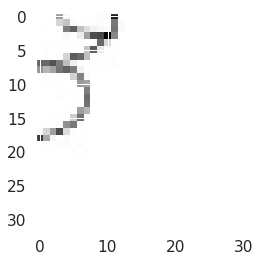

orig 1 classified as 0


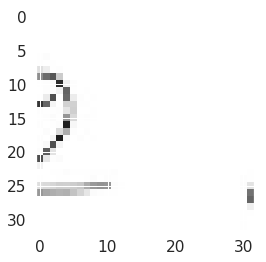

orig 1 classified as 0


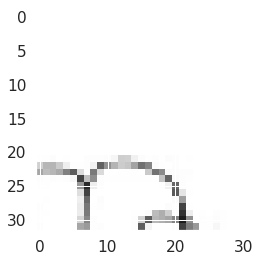

orig 0 classified as 1


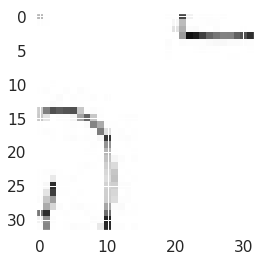

orig 0 classified as 1


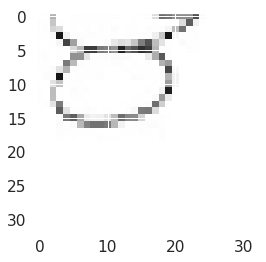

orig 0 classified as 1


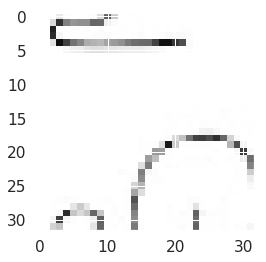

orig 0 classified as 1


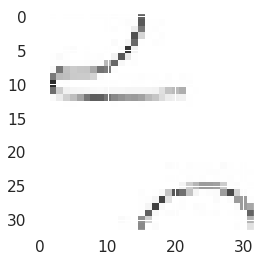

orig 1 classified as 0


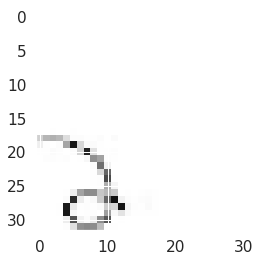

orig 1 classified as 0


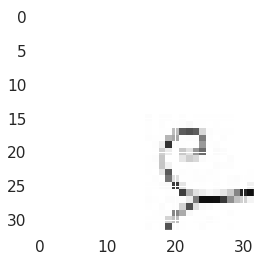

orig 0 classified as 1


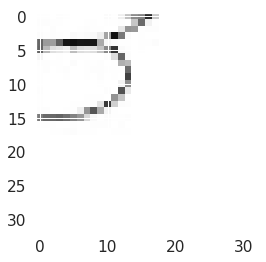

orig 0 classified as 1


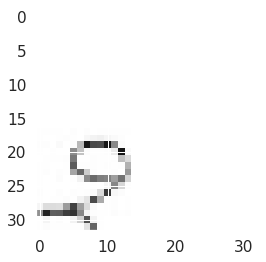

orig 1 classified as 0


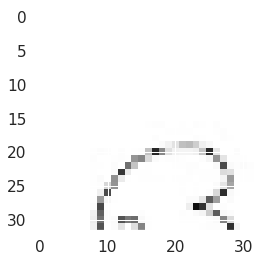

orig 0 classified as 1


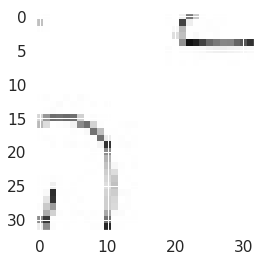

orig 1 classified as 0


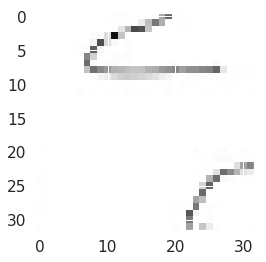

orig 0 classified as 1


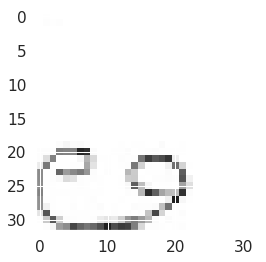

orig 0 classified as 1


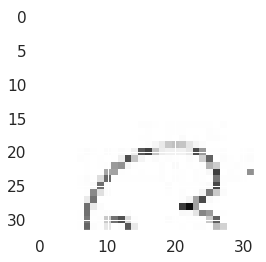

orig 1 classified as 0


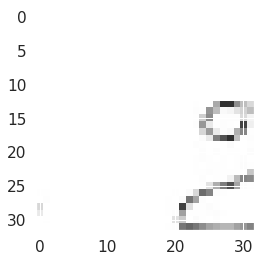

orig 1 classified as 0


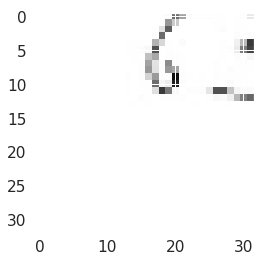

orig 0 classified as 1


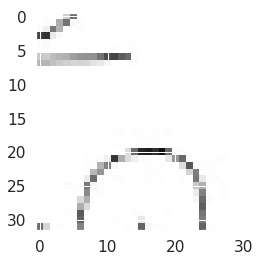

orig 0 classified as 1


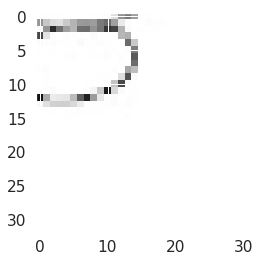

orig 0 classified as 1


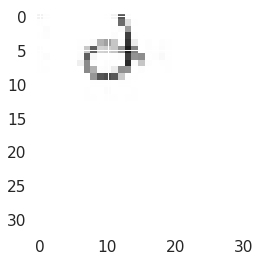

orig 0 classified as 1


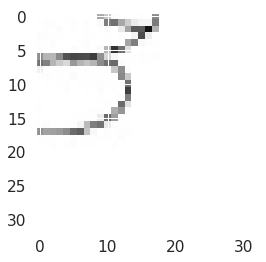

orig 1 classified as 0


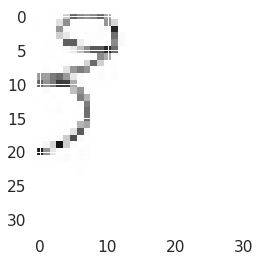

orig 0 classified as 1


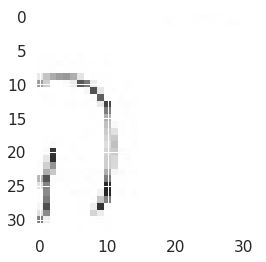

orig 1 classified as 0


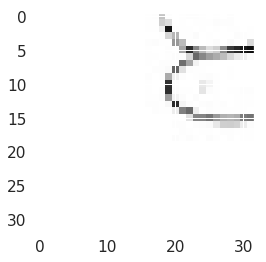

orig 0 classified as 1


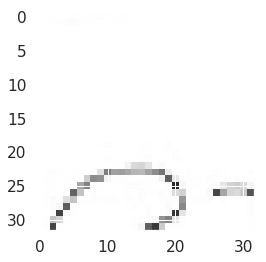

orig 1 classified as 0


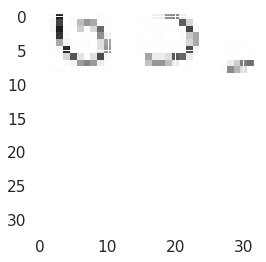

orig 0 classified as 1


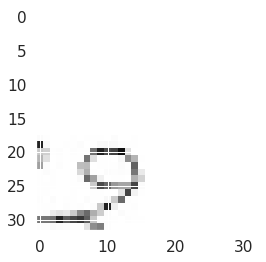

orig 1 classified as 0


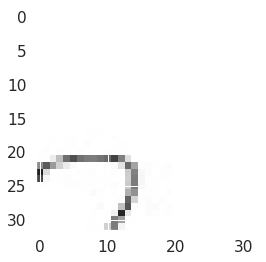

orig 0 classified as 1


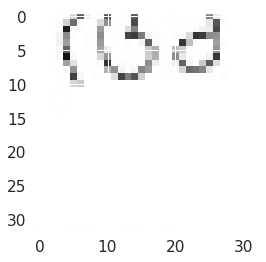

orig 0 classified as 1


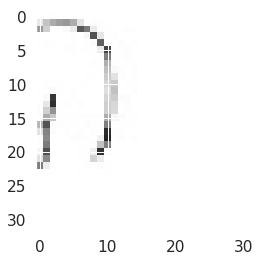

orig 0 classified as 1


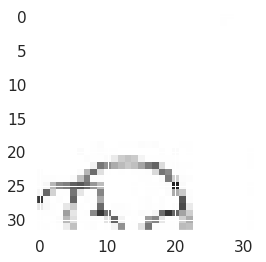

orig 0 classified as 1


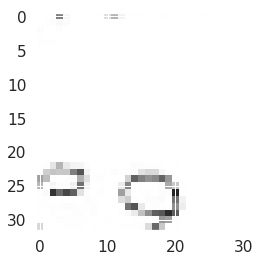

orig 0 classified as 1


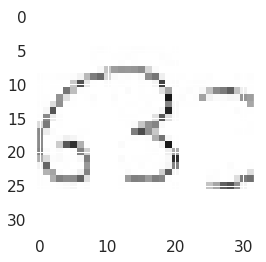

orig 0 classified as 1


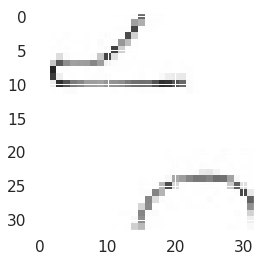

orig 0 classified as 1


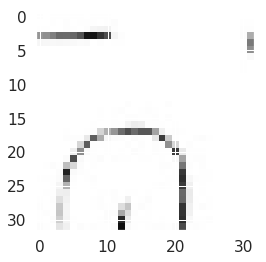

orig 0 classified as 1


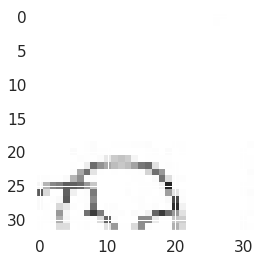

Images mis-classified 227


In [122]:
view_img(y_true, y_pred)

In [0]:
from keras.utils import plot_model

In [0]:
plot_model(net, to_file='model.png')